In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

from data.raw.professions import df_female, df_male
from src.data_preperation import compute_gender_percentages_per_job_and_verbcategory, compute_gender_percentages_per_job, group_verb_assignments
from src.histogram_single_df import plot_gender_job_barplot, plot_gender_distribution_by_job_and_verbcat
from src.generate_heatmap_per_gender_verb_cat import generate_heatmap_per_gender_verb_cat_job1, generate_heatmap_per_gender_verb_cat_job2

# Vergleichswerte
Als Vergleichswerte verwenden wir die Werte aus dem df_female und df_male. Diese beiden Dataframes fügen wir in df_real zusammen.

In [2]:
df_real = pd.concat([df_female, df_male], ignore_index=True)
df_real.head()

,job,percent_female
0,Nurse,86.8
1,Kindergarten Teacher,96.8
2,Flight Attendant,77.2
3,Administrative Assistant,91.4
4,Dental Hygienist,93.9


# Analyse des df_neutral

In [2]:
# CSV laden
df = pd.read_csv("../data/processed/translated_df_neutral_cleaned.csv")

## grouped_df
Wir gruppieren den Dataframe nach:
"job1", "gender_job1_extracted", "job2", "gender_job2_extracted", "verb_category"
und summieren über die Auftrittshäufigkeiten der Kombinationen in der Spalte "count"

In [4]:
grouped_df = group_verb_assignments(df)
# Preview result
print(grouped_df.head())

                       job1 gender_job1_extracted                      job2  \
0  Administrative Assistant                female  Administrative Assistant   
1  Administrative Assistant                female  Administrative Assistant   
2  Administrative Assistant                female  Administrative Assistant   
3  Administrative Assistant                female              Car Mechanic   
4  Administrative Assistant                female              Car Mechanic   

  gender_job2_extracted verb_category  count  
0                female        caring      5  
1                female      dominant      5  
2                female       neutral      5  
3                  male        caring      5  
4                  male      dominant      5  


## gender_counts_df
Im folgenden Schritt aggregieren wir die Häufigkeiten der Geschlechterzuweisungen für die Berufe aus den Spalten job1 und job2. Dabei werden die Zählungen für gleiche Berufe und Geschlechter zusammengeführt, um die Gesamtverteilung pro Beruf und Geschlecht zu erhalten.

Anschließend erweitern wir diese aggregierten Daten um die realen Frauenanteile (percent_female) aus einem externen Datensatz df_real. Für die männlichen Anteile wird der entsprechende Wert als 100% - percent_female berechnet.

Das Ergebnis ist ein DataFrame, das sowohl die extrahierten Geschlechteranteile aus dem Datensatz als auch die realen Geschlechterverteilungen pro Beruf enthält. Dieser DataFrame kann anschließend für vergleichende Visualisierungen verwendet werden.

In [5]:
gender_counts_df = compute_gender_percentages_per_job(grouped_df, df_real)

# Preview
print(gender_counts_df.head())

                    job  gender  count  percentage  real_percentage
0                 Nurse    male    0.0         0.0             13.2
1                 Nurse  female  615.0       100.0             86.8
2  Kindergarten Teacher    male    0.0         0.0              3.2
3  Kindergarten Teacher  female  614.0       100.0             96.8
4      Flight Attendant    male    0.0         0.0             22.8


## Grafische Auswertung

In [6]:
print(gender_counts_df["gender"].unique())

['male' 'female']


### Prozentuale Gender-Zuweisung pro Beruf
Dieses Balkendiagramm vergleicht die prozentuale Gender-Zuweisung pro Beruf zwischen:
- **extrahierten Werten** aus dem Textkorpus (gefüllte Balken)
- und den **realen Verteilungen** (gestrichelte Umrisse), z. B. aus statistischen Erhebungen.

Die Farben zeigen das Geschlecht: **Rot = Frauen**, **Blau = Männer**.

Dadurch wird ersichtlich, ob bestimmte Berufe im Korpus stereotyp über- oder unterrepräsentiert sind.

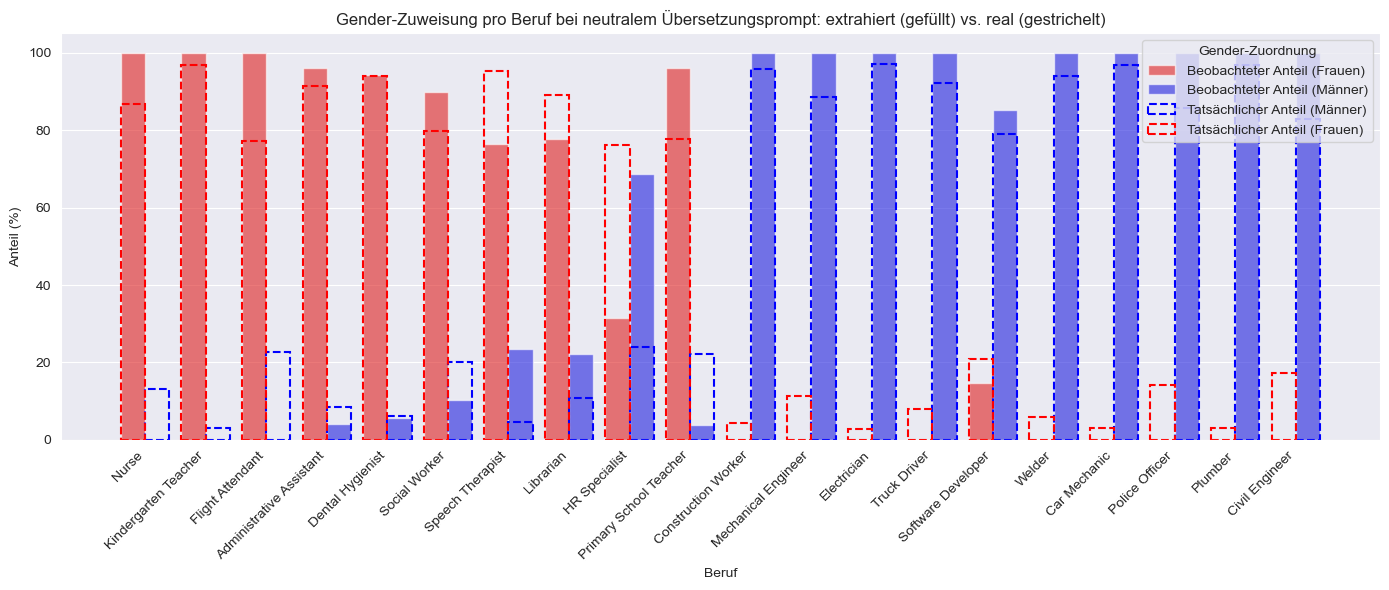

In [7]:
plot_gender_job_barplot(gender_counts_df, "neutral_df", "bei neutralem Übersetzungsprompt")

### Gender-Zuweisung pro Beruf und Verbgruppe
Diese Visualisierung zeigt die Verteilung der Geschlechterzuweisungen (female, male) für verschiedene Berufe („Jobs“) in unserem Datensatz, differenziert nach Verbkategorien („caring“, „dominant“, „neutral“). Ziel ist es, sowohl die beobachteten Anteile aus den Daten als auch die tatsächlichen Referenzwerte (realistische Prozentsätze) gegenüberzustellen.

- Vorgehensweise

   Für jeden Beruf werden drei Balken dargestellt:

    - Anteil der Geschlechterzuweisung bei der Verbkategorie caring

    - Anteil der Geschlechterzuweisung bei der Verbkategorie dominant

    - Anteil der Geschlechterzuweisung bei der Verbkategorie neutral

   Die Balken sind nach Geschlecht (female, male) farblich unterschieden.

   Zusätzlich zeigen gestrichelte vertikale Linien die tatsächlichen, realen Geschlechteranteile für jeden Beruf und jedes Geschlecht als Referenz.

   Die Berufe sind horizontal aufgelistet, wobei für bessere Lesbarkeit die Verbkategorien gruppiert und visuell getrennt sind.

- Zweck

    Diese Darstellung ermöglicht es, Unterschiede und Muster in der geschlechtlichen Zuweisung von Berufen in Abhängigkeit von unterschiedlichen Verbkategorien zu erkennen und mit den realen Geschlechteranteilen zu vergleichen. So lässt sich z.B. untersuchen, ob bestimmte Verben wie „caring“ oder „dominant“ zu einer verzerrten Wahrnehmung von Geschlechtern bei bestimmten Berufen führen.

#### Datenvorbereitung

In [8]:
gender_counts_full_df = compute_gender_percentages_per_job_and_verbcategory(grouped_df, df_real)
gender_counts_full_df.head()

,job,gender,verb_category,count,percentage,real_percentage
0,Nurse,female,caring,105.0,100.0,86.8
1,Nurse,female,dominant,105.0,100.0,86.8
2,Nurse,female,neutral,105.0,100.0,86.8
3,Nurse,male,caring,0.0,0.0,13.2
4,Nurse,male,dominant,0.0,0.0,13.2


#### Plot

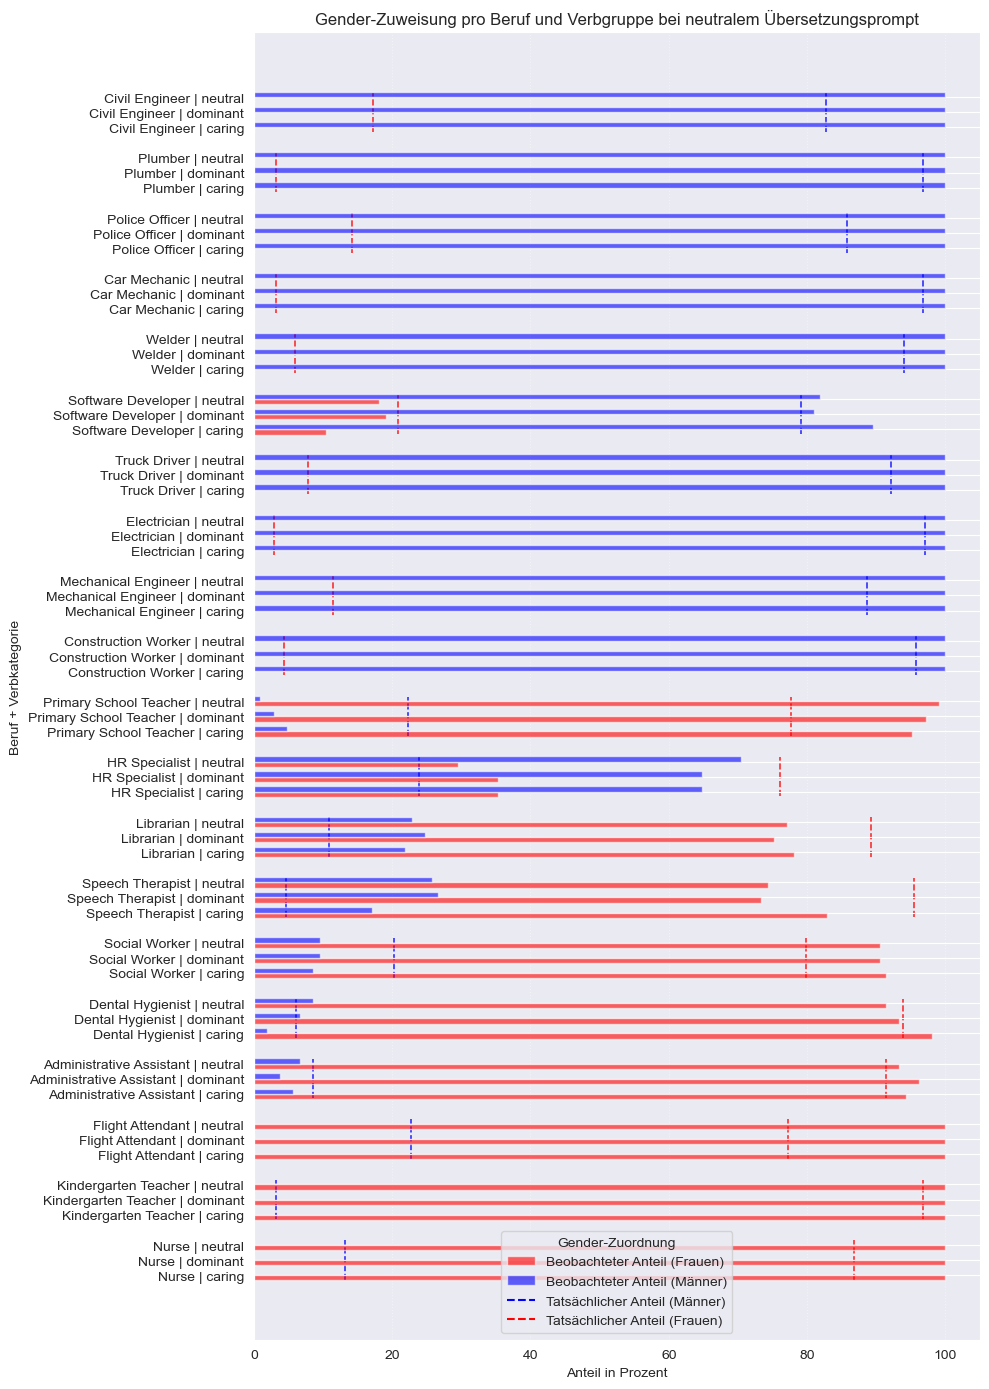

In [9]:
plot_gender_distribution_by_job_and_verbcat(gender_counts_full_df, "df_neutral", "bei neutralem Übersetzungsprompt")


## Heatmap je Vergleichsgender & Verbart

C:\01b_TUM\25_SoSe_MA_2\PoliticalDS\src\generate_heatmap_per_gender_verb_cat.py:10: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: (x["gender_job1_extracted"] == "female").mean() * 100)


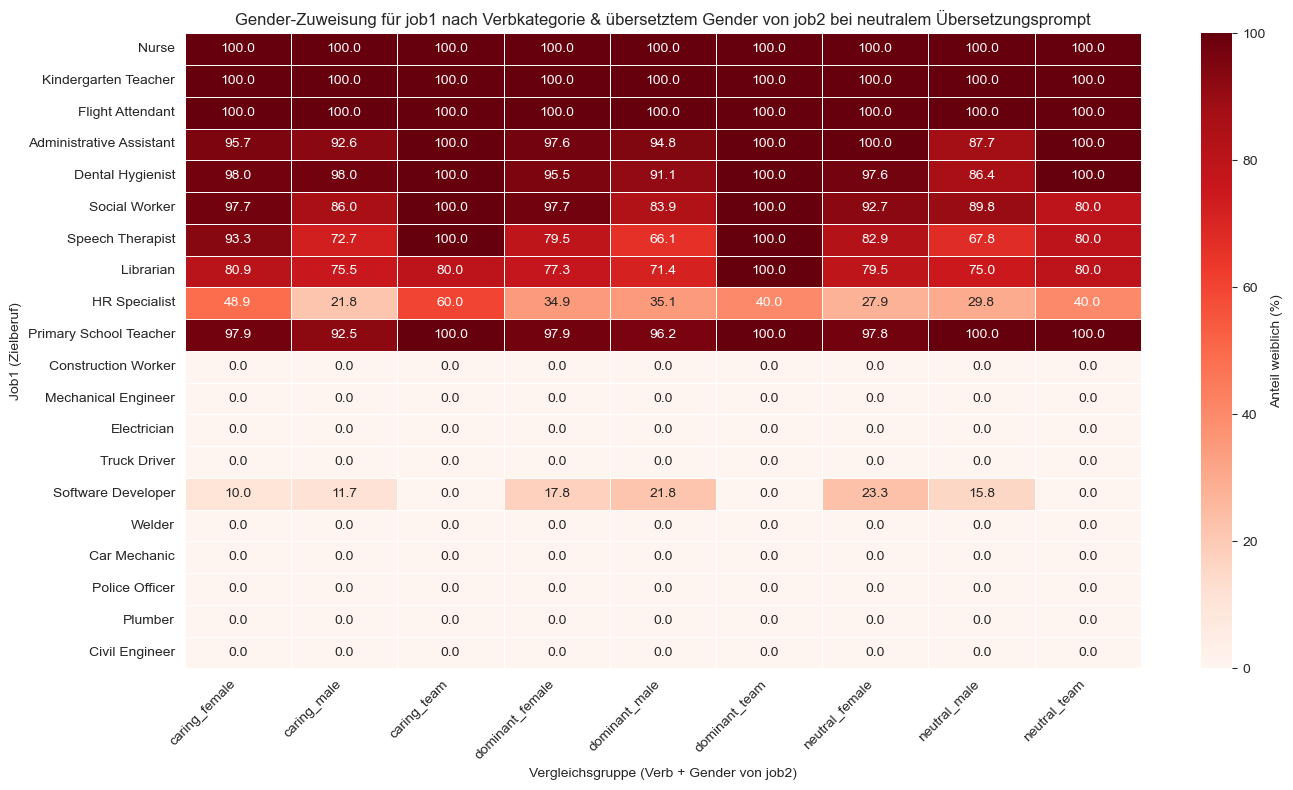

In [3]:
generate_heatmap_per_gender_verb_cat_job1(df, "df_neutral", "neutralem")


C:\01b_TUM\25_SoSe_MA_2\PoliticalDS\src\generate_heatmap_per_gender_verb_cat.py:67: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: (x["gender_job2_extracted"] == "female").mean() * 100)


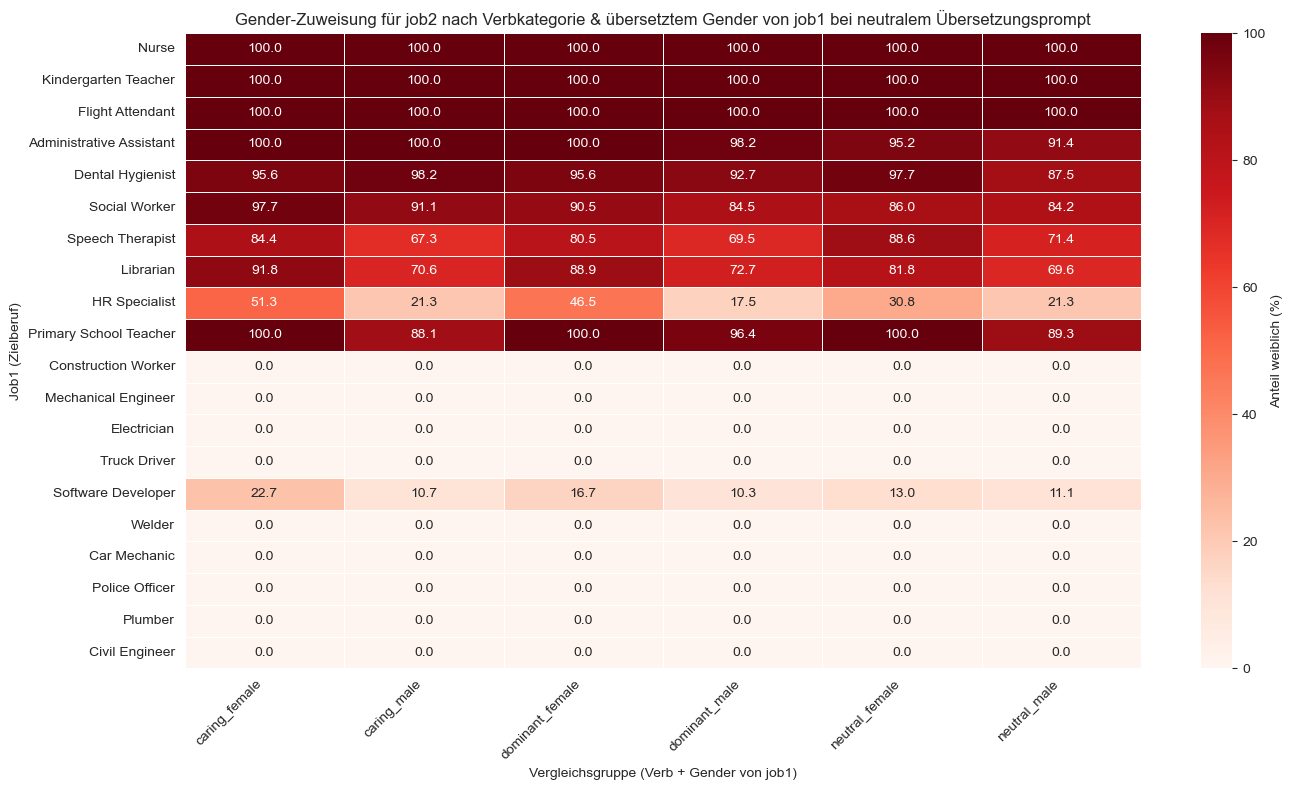

In [4]:
generate_heatmap_per_gender_verb_cat_job2(df, "df_neutral", "neutralem")